In [1]:
import matplotlib
import pickle

from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from meth5 import MetH5File

from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from nanoepitools.reference_cpgs import ReferenceCpGs

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from benchmark_pycometh.utils import unions
from benchmark_pycometh.config import module_config
from benchmark_pycometh.diffmet.diffmet_results import Results

In [2]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})
reference_cpgs = ReferenceCpGs(module_config.reference)
m5_path = module_config.meth5_template_file.format(sample="HG002")
results_cache_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/pycometh/asm/all_results_cache.pkl"
load_from_cache=True

In [3]:
def get_result_file(caller, segmentation=None, test=None, ihw=False, segments_per_window=None, window_size=None):
    basedir = Path("/home/r933r/data/projects/nanopore/pycometh_benchmark/")

    if caller == "methcp":
        return basedir.joinpath("bs/mock_bsseq_from_nanopore/HG002_mockbsseq_segments_methcp_diffmet.tsv")

    basedir = basedir.joinpath("pycometh/asm")

    ihw = f"ihw_{'yes' if ihw else 'no'}"
    if segmentation == "pycometh":
        fn = f"HG002_diffmet_{window_size}_{segments_per_window}_hyp_{test}_{ihw}.tsv"
        return basedir.joinpath("cpg", "diffmet", fn)

    basedir = basedir.joinpath(f"diffmet_{segmentation}/cpg")
    fn = f"HG002_diffmet_hyp_{test}_{ihw}.tsv"
    return basedir.joinpath(fn)

def get_all_result_files():
    yield {"key":"MethCP", "file":get_result_file("methcp", "methcp"), "caller": "methcp"}
    for label, segmentation in  ("PycoMeth", "pycometh"), ("PycoMeth (MethylKit)", "methylkit"), ("PycoMeth (MethCP)", "methcp"):
        for ihw in True, False:
            for test_label, test in ("BS Diff", "bs_diff"), ("LLR-Diff", "llr_diff"), ("Fisher-E","count_dependency"):
                name = f"{label} {test_label}{' (IHW)' if ihw else ''}"
                if segmentation == "pycometh":
                    yield {"key": name + " coarse", "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw, 12, 300)}
                    yield {"key": name, "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw, 20, 300)}
                else:
                    yield {"key": name, "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw)}


In [4]:
if load_from_cache:
    with open(results_cache_file, "rb") as f:
        results = pickle.load(f)
else:
    results = Results(reference_cpgs, m5_path, include_chroms={"20"})

In [8]:
for res_config in get_all_result_files():
    if res_config["key"] not in results.segments:
        results.load_segments(**res_config)

Loading PycoMeth (MethylKit) Fisher-E (IHW)
Filtering chromosomes
Annotating CpGs for PycoMeth (MethylKit) Fisher-E (IHW)
Loading diffmet for PycoMeth (MethylKit) Fisher-E (IHW) (976 segments)
Finished loading PycoMeth (MethylKit) Fisher-E (IHW) (974 segments)
Loading PycoMeth (MethylKit) BS Diff
Filtering chromosomes
Annotating CpGs for PycoMeth (MethylKit) BS Diff
Loading diffmet for PycoMeth (MethylKit) BS Diff (442 segments)
Finished loading PycoMeth (MethylKit) BS Diff (440 segments)
Loading PycoMeth (MethylKit) LLR-Diff
Filtering chromosomes
Annotating CpGs for PycoMeth (MethylKit) LLR-Diff
Loading diffmet for PycoMeth (MethylKit) LLR-Diff (1311 segments)
Finished loading PycoMeth (MethylKit) LLR-Diff (1308 segments)
Loading PycoMeth (MethylKit) Fisher-E
Filtering chromosomes
Annotating CpGs for PycoMeth (MethylKit) Fisher-E
Loading diffmet for PycoMeth (MethylKit) Fisher-E (992 segments)
Finished loading PycoMeth (MethylKit) Fisher-E (990 segments)
Loading PycoMeth (MethCP) BS D

In [ ]:
del results.reference_cpgs.ref
with open(results_cache_file, "bw") as f:
    pickle.dump(results, f)

In [5]:
results.colors = {}
for key in results.segments:
    if key == "MethCP":
        results.colors[key] = "#88498F"
    elif "(MethCP)" in key:
        results.colors[key] = "#C492B1"
    elif "(MethylKit)" in key:
        results.colors[key] = "#49C6E5"
    elif "coarser" in key:
        results.colors[key] = "#C96300"
    elif "coarse" in key:
        results.colors[key] = "#ED7400"
    else:
        results.colors[key] = "#D58936"

results.patterns = {}
for key in results.segments:
    if "LLR-Diff" in key:
        if "IHW" in key:
            results.patterns[key] = "O"
        else:
            results.patterns[key] = "/"
    elif "BS Diff" in key:
        if "IHW" in key:
            results.patterns[key] = "."
        else:
            results.patterns[key] = "\\"
    elif "Fisher-E" in key:
        if "IHW" in key:
            results.patterns[key] = "o"
        else:
            results.patterns[key] = "-"
    else:
        results.patterns[key] = ""

In [52]:
def plot_bar_diffmetcolored(x, key, diffmet_thresholds = [0.2, 0.3, 0.4, 0.6, 0.8, 1.0], cmap="jet"):
    cmap = matplotlib.cm.get_cmap(cmap)
    last_thres = 0.1
    left = 0
    segments = results.segments[key]
    for thres in diffmet_thresholds:
        color = cmap((thres+last_thres)/2)
        idx = segments["diffmet"].map(lambda x: last_thres < abs(x) <= thres)
        n = get_num_dmr_cpgs(key, additional_index=idx)
        plt.barh(x, n, left=left, color=color)
        left += n
        last_thres = thres

In [6]:
def get_dmrs(key, pval_thres = 0.05, min_diff = 0.1, additional_index=None):
    segments = results.segments[key]
    if additional_index is not None:
        segments = segments.loc[additional_index]
    segments = segments.loc[segments["adj_pvalue"] < pval_thres]
    segments = segments.loc[segments["diffmet"].map(lambda x: abs(x) > min_diff)]
    return segments

def get_num_dmr_cpgs(key, **kwargs):
    dmrs = get_dmrs(key, **kwargs)
    return len(unions(dmrs["CpGs"]))

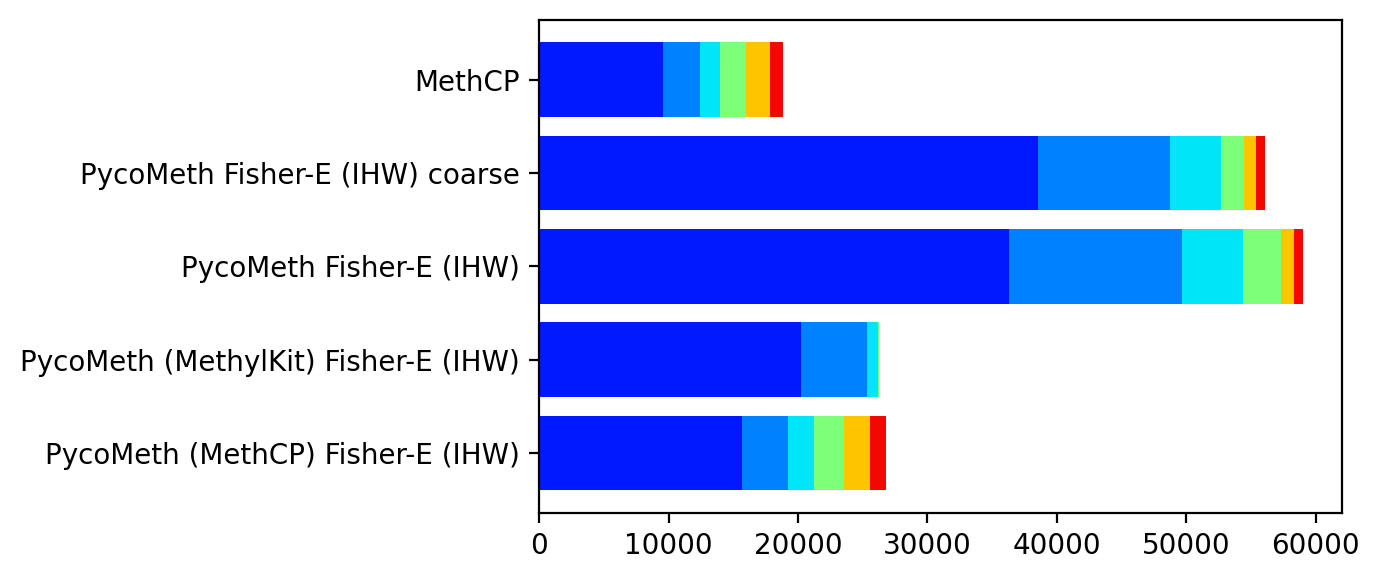

In [66]:
with pa.open_multipage_pdf("asm_hg002_fisher_ihw"):
    tools = ["MethCP", 'PycoMeth Fisher-E (IHW) coarse', 'PycoMeth Fisher-E (IHW)', 'PycoMeth (MethylKit) Fisher-E (IHW)', 'PycoMeth (MethCP) Fisher-E (IHW)'][::-1]
    pa.figure(figsize=(7, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

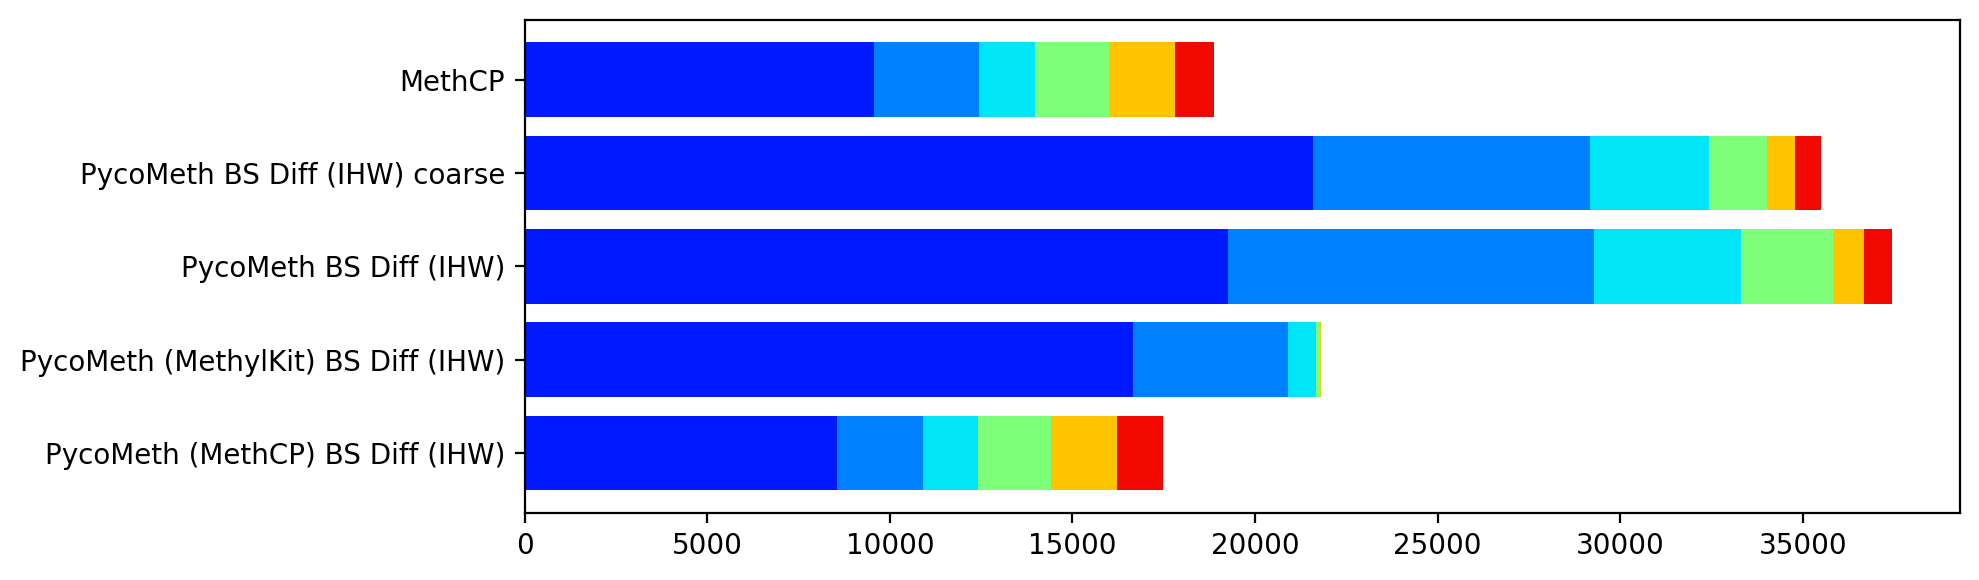

In [55]:
with pa.open_multipage_pdf("asm_hg002_bs_diff_ihw"):
    tools = ["MethCP", 'PycoMeth BS Diff (IHW) coarse', 'PycoMeth BS Diff (IHW)', 'PycoMeth (MethylKit) BS Diff (IHW)', 'PycoMeth (MethCP) BS Diff (IHW)'][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

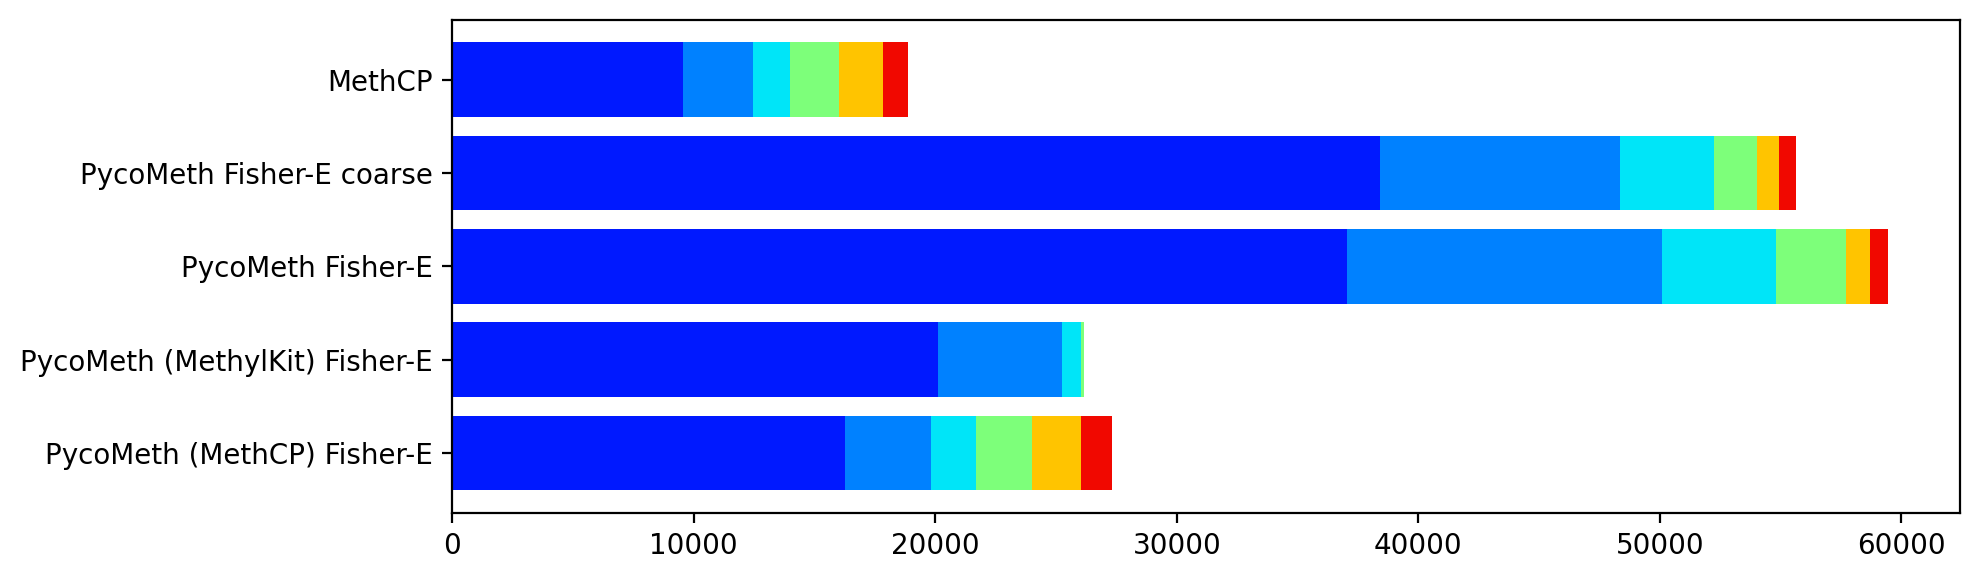

In [56]:
with pa.open_multipage_pdf("asm_hg002_fisher"):
    tools = ["MethCP", 'PycoMeth Fisher-E coarse', 'PycoMeth Fisher-E', 'PycoMeth (MethylKit) Fisher-E', 'PycoMeth (MethCP) Fisher-E'][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

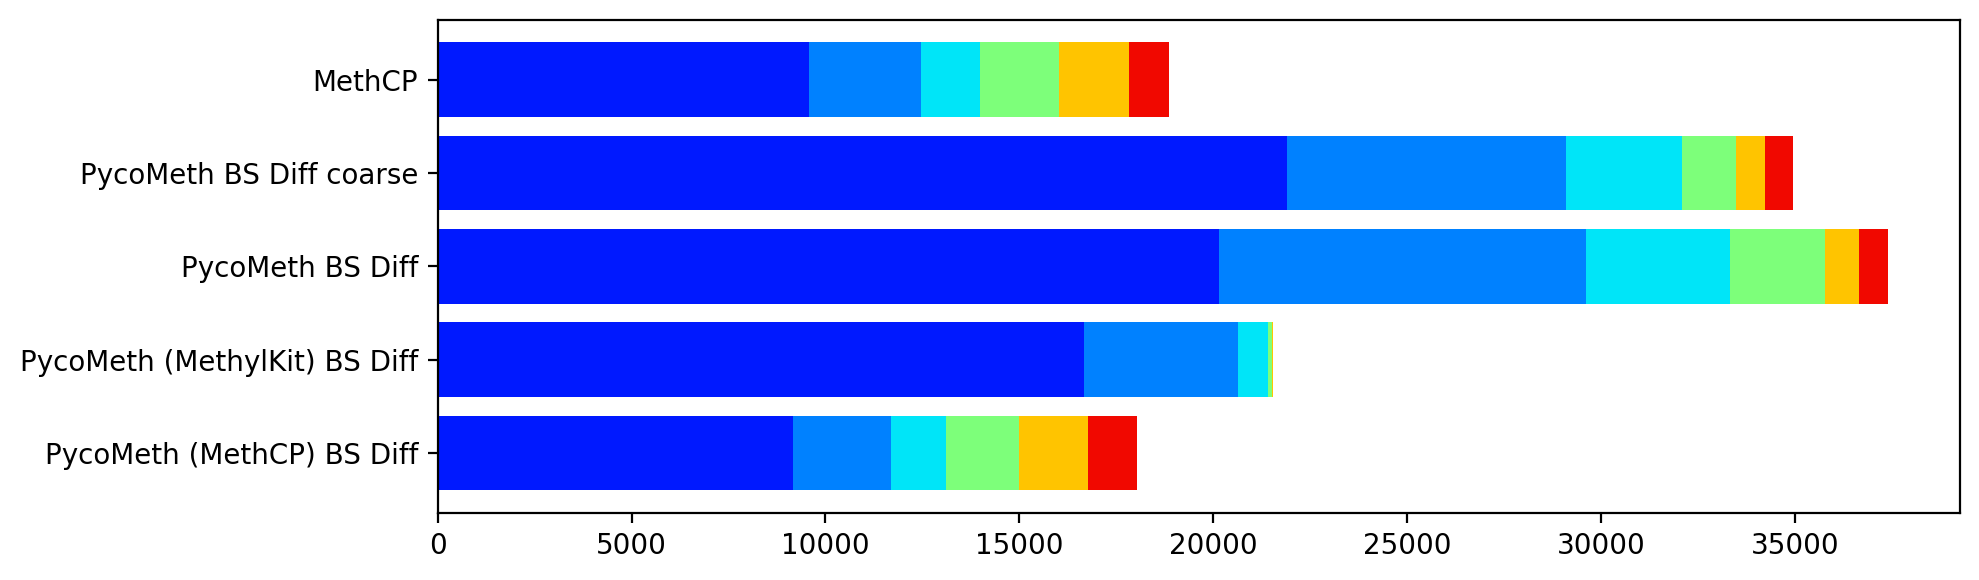

In [57]:
with pa.open_multipage_pdf("asm_hg002_bs_diff"):
    tools = ["MethCP", 'PycoMeth BS Diff coarse', 'PycoMeth BS Diff', 'PycoMeth (MethylKit) BS Diff', 'PycoMeth (MethCP) BS Diff'][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

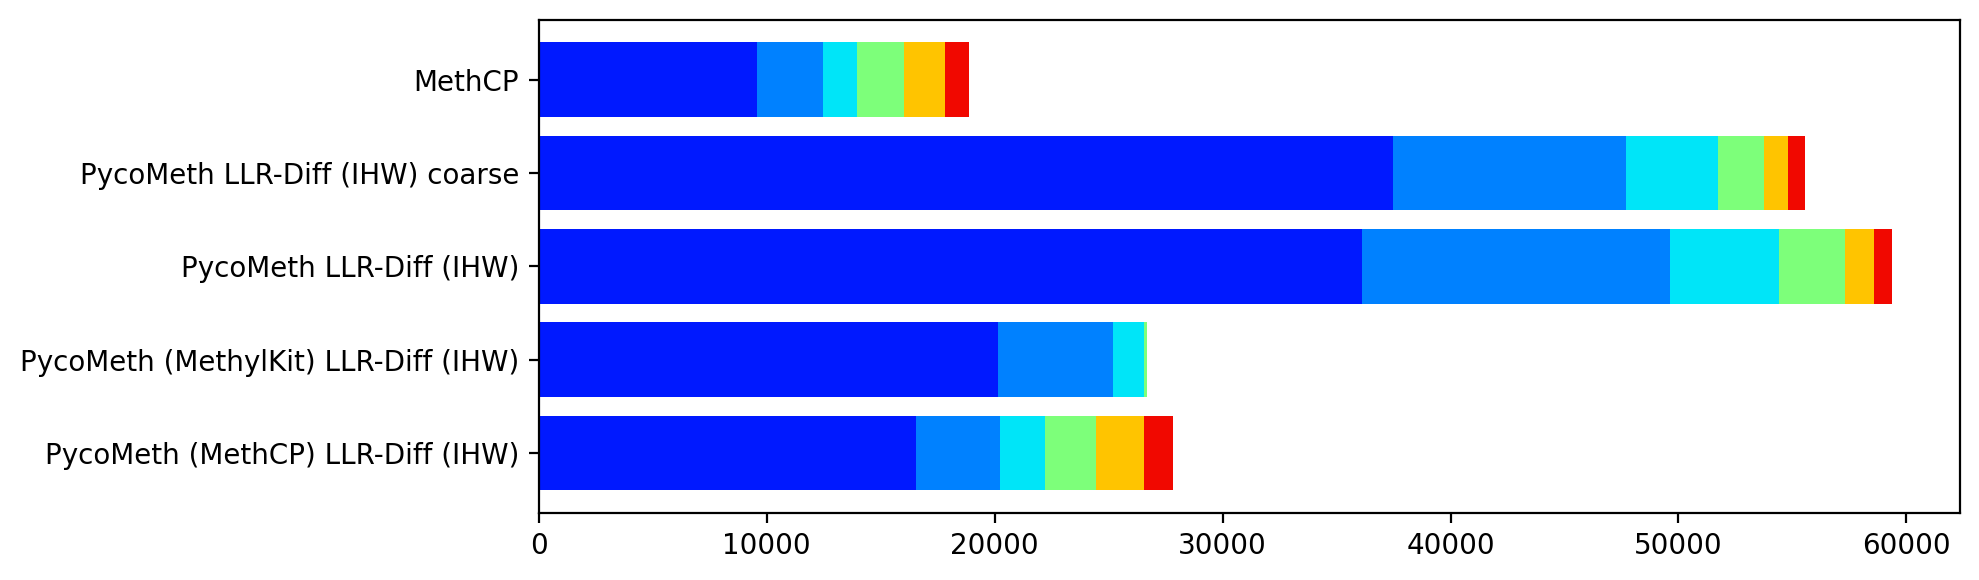

In [58]:
with pa.open_multipage_pdf("asm_hg002_llr_diff_ihw"):
    tools = ["MethCP", 'PycoMeth LLR-Diff (IHW) coarse', 'PycoMeth LLR-Diff (IHW)', 'PycoMeth (MethylKit) LLR-Diff (IHW)', 'PycoMeth (MethCP) LLR-Diff (IHW)'][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

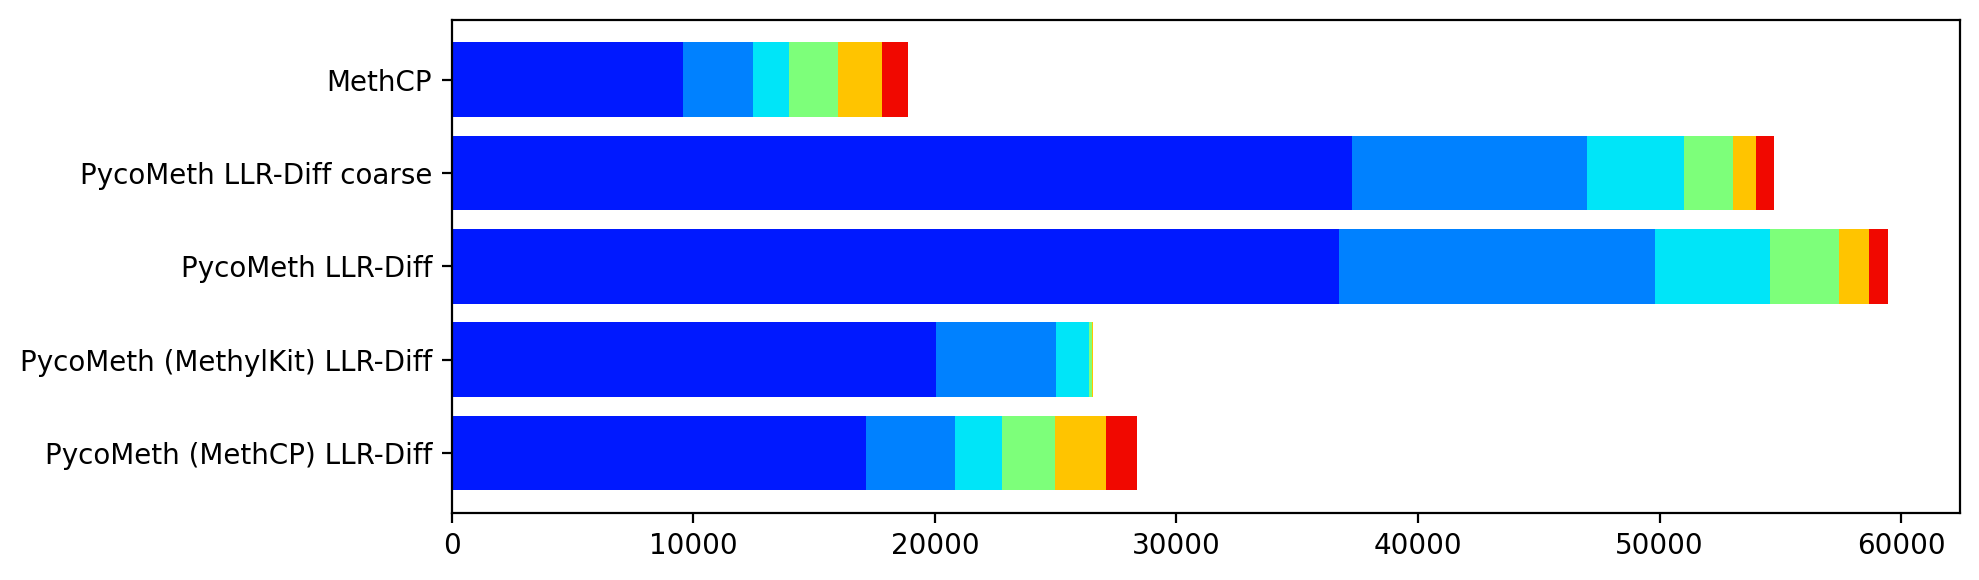

In [59]:
with pa.open_multipage_pdf("asm_hg002_llr_diff"):
    tools = ["MethCP", 'PycoMeth LLR-Diff coarse', 'PycoMeth LLR-Diff', 'PycoMeth (MethylKit) LLR-Diff', 'PycoMeth (MethCP) LLR-Diff'][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

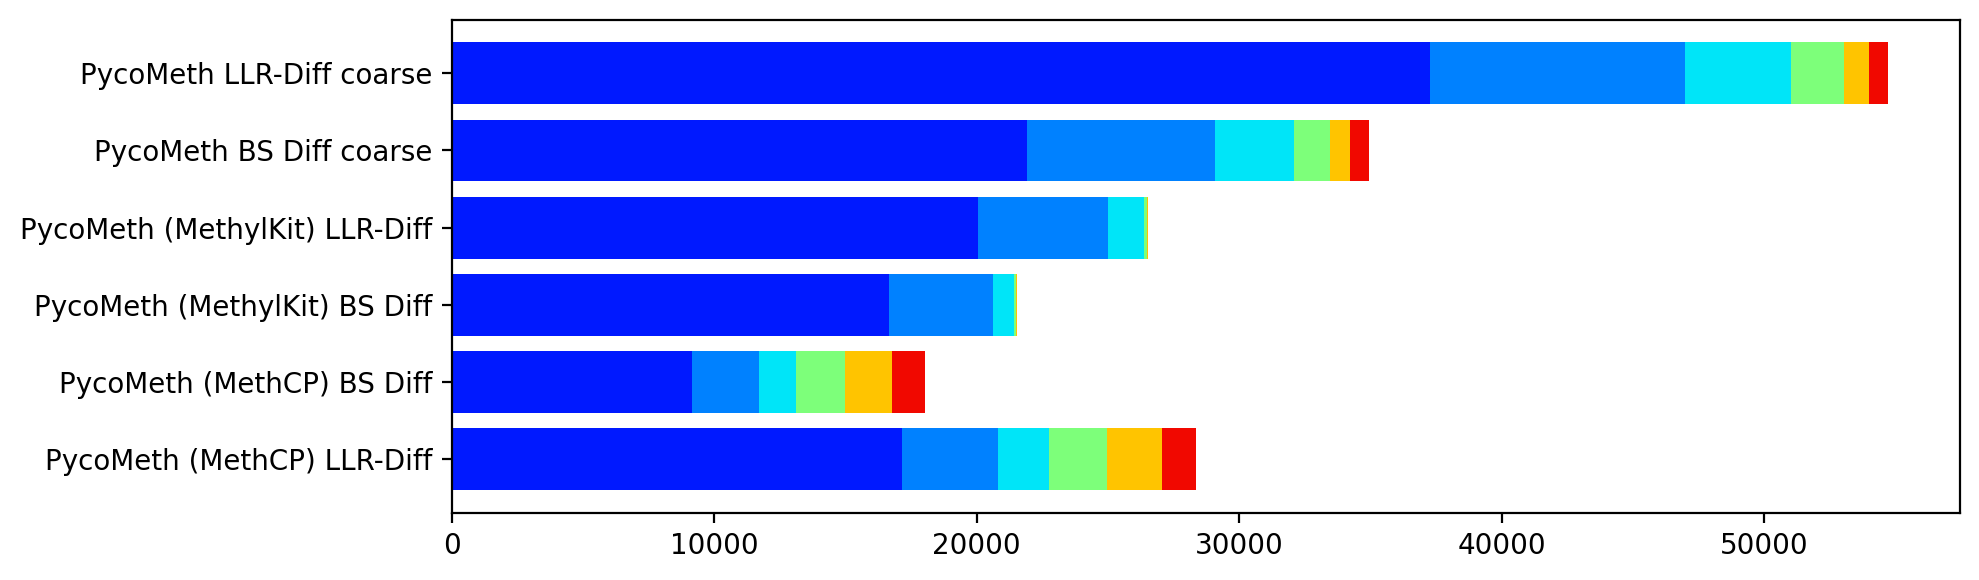

In [60]:
with pa.open_multipage_pdf("asm_hg002_llr_diff_vs_bs_diff"):
    tools = ["PycoMeth LLR-Diff coarse", "PycoMeth BS Diff coarse", "PycoMeth (MethylKit) LLR-Diff", "PycoMeth (MethylKit) BS Diff", "PycoMeth (MethCP) BS Diff", "PycoMeth (MethCP) LLR-Diff"][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()


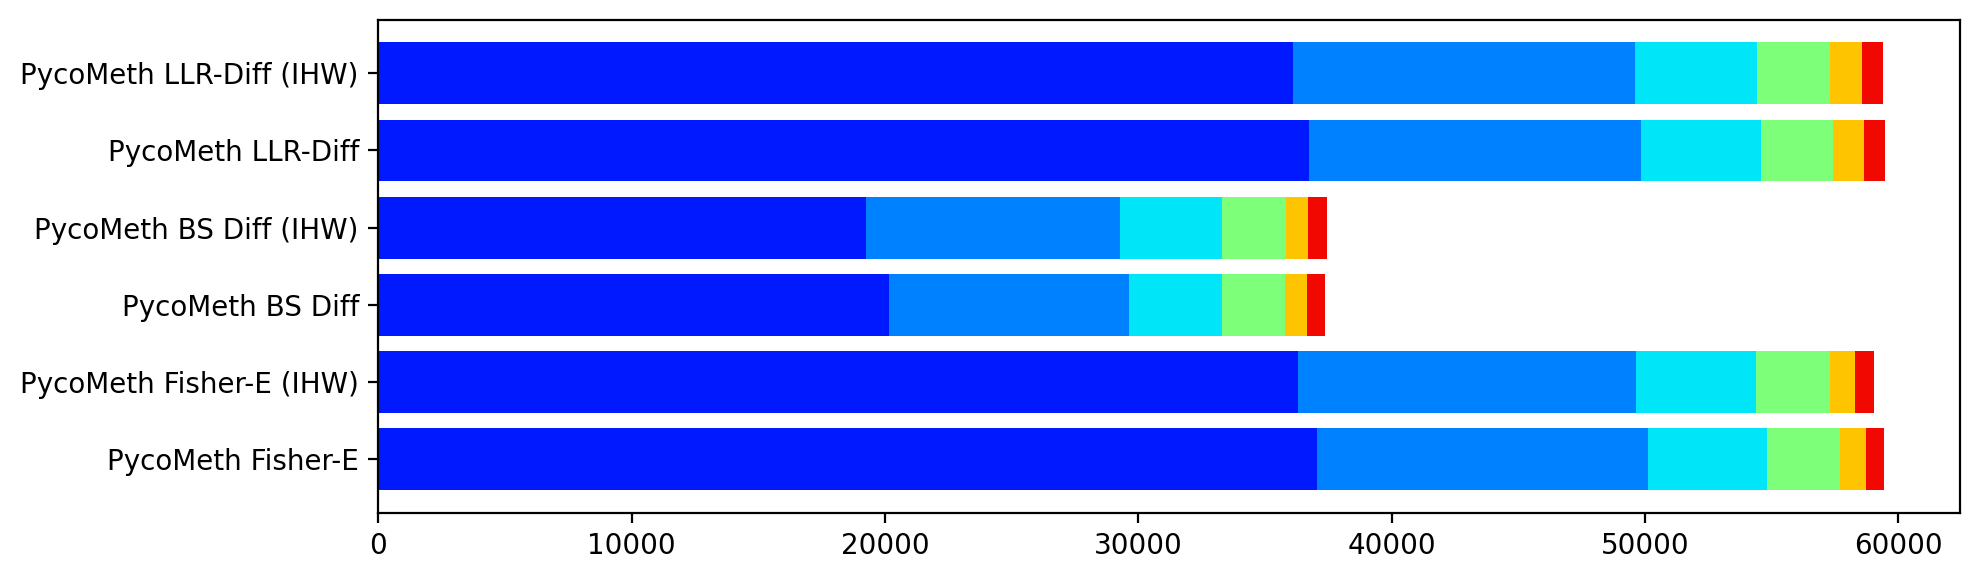

In [61]:
with pa.open_multipage_pdf("asm_hg002_ihw_vs_no_ihw"):
    tools = ["PycoMeth LLR-Diff (IHW)", "PycoMeth LLR-Diff", "PycoMeth BS Diff (IHW)", "PycoMeth BS Diff", "PycoMeth Fisher-E (IHW)", "PycoMeth Fisher-E"][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()


In [25]:
tools = ["MethCP", 'PycoMeth Fisher-E (IHW) coarse', 'PycoMeth Fisher-E (IHW)', 'PycoMeth (MethylKit) Fisher-E (IHW)', 'PycoMeth (MethCP) Fisher-E (IHW)'][::-1]
for tool in tools:
    segments = results.segments[tool]
    idx = segments["diffmet"].map(lambda x: 0.1 < abs(x) < 0.3)
    idx2 = segments["diffmet"].map(lambda x: abs(x) >= 0.3)
    print(tool, get_num_dmr_cpgs(tool),
          get_num_dmr_cpgs(tool, additional_index=idx),
          get_num_dmr_cpgs(tool, additional_index=idx) /  get_num_dmr_cpgs(tool) * 100,
          get_num_dmr_cpgs(tool, additional_index=idx2),
          get_num_dmr_cpgs(tool, additional_index=idx2) /  get_num_dmr_cpgs(tool) * 100)

PycoMeth (MethCP) Fisher-E (IHW) 37821 29570 78.18407762883054 8251 21.815922371169457
PycoMeth (MethylKit) Fisher-E (IHW) 33826 31591 93.39265653639212 2235 6.607343463607876
PycoMeth Fisher-E (IHW) 78059 65715 84.18632060364595 12344 15.813679396354042
PycoMeth Fisher-E (IHW) coarse 77054 66307 86.05263840942715 10747 13.947361590572847
MethCP 42936 29450 68.59046021986211 13486 31.40953978013788
